In [41]:
import numpy as np
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 定义超参数

In [42]:
train_batch_size = 10    #每批处理的训练集数据
test_batch_size = 10     #每批处理的测试集数据
learning_rate = 0.001     #学习率
num_epoches = 50          #训练数据集的轮次

In [43]:
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

In [44]:
train_x.shape, train_y.shape

((784, 5000), (10, 5000))

In [45]:
test_x.shape, test_y.shape

((784, 5000), (10, 5000))

In [46]:
train_x[:,0].shape,train_y[:,0].shape

((784,), (10,))

## 可视化输入图像 

label: 5


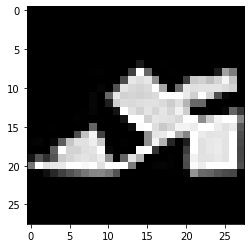

In [47]:
index = np.random.randint(train_x.shape[1])
img = train_x[:,index].reshape(28,28,1,order='C')
plt.imshow(img, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
print('label:',np.argmax(train_y[:,index],axis=0))

## 构建原始数据集

In [48]:
train_dataset = []  # 训练集
test_dataset = []   # 测试集
for i in range(train_x.shape[1]):
    train_dataset.append([train_x[:,i].reshape(28,28,1,order='C'),np.argmax(train_y[:,i],axis=0)])
for i in range(test_x.shape[1]):
    test_dataset.append([test_x[:,i].reshape(28,28,1,order='C'),np.argmax(test_y[:,i],axis=0)])

In [49]:
#训练集
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
#测试集
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [50]:
train_loader.dataset[0][0].shape

(28, 28, 1)

In [51]:
transform = transforms.Compose([
    transforms.ToTensor(),                                               # 归一化
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # 标准化
])

In [52]:
def out(w,k,s,p):
    return (w-k+2*p)/s+1
out(6,3,1,1)

6.0

In [53]:
class Net(nn.Module):
    def __init__(self,num_classes=10):
        super(Net,self).__init__()
        self.features = nn.Sequential(  #打包
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),     # input[1, 28, 28]  output[16, 28, 28] 
            nn.ReLU(),      
            nn.MaxPool2d(kernel_size=2),                              # output[16, 14, 14] 
            nn.Conv2d(16, 48, kernel_size=3, stride=1, padding=0),    # output[48, 12, 12]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                              # output[48, 6, 6]
            nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1),    # output[96, 6, 6]
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(96*6*6,1024),
            nn.ReLU(),
            nn.Linear(1024,128),
            nn.ReLU(),
            nn.Linear(128,num_classes),
        )
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.classifier(x)
        return x

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model = model.to(device)
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=3456, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [55]:
# 损失器
criterion = nn.CrossEntropyLoss().to(device)
# 优化器
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0)

In [56]:
train_loss = []         
test_loss = []
train_acc  = []    
test_acc  = []     

In [57]:
for epoch in range(num_epoches):
    print('epoch:',epoch+1)

    model.train()
    for _,data in enumerate(train_loader,0):
        inputs, labels = data[0],data[1]
        inputs = inputs.view(train_batch_size, 1, 28, 28)  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 每次训练梯度清零
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    model.eval()
    running_loss = 0.0
    correct = 0             
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(train_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, 1, 28, 28)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    train_loss.append(running_loss/total)
    train_acc.append(correct / total)
    print("训练集上的损失：%.3f" % (running_loss / total))
    print("训练集上的准确率：%.3f" % (correct / total))

    
    model.eval()
    running_loss = 0.0
    correct = 0            
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(test_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, 1, 28, 28)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    test_loss.append(running_loss / total)
    test_acc.append(correct / total)
    print("测试集上的损失：%.3f" % (running_loss / total))
    print("测试集上的准确率：%.3f" % (correct / total))

epoch: 1
训练集上的损失：0.058
训练集上的准确率：0.775
测试集上的损失：0.068
测试集上的准确率：0.745
epoch: 2
训练集上的损失：0.039
训练集上的准确率：0.864
测试集上的损失：0.052
测试集上的准确率：0.810
epoch: 3
训练集上的损失：0.030
训练集上的准确率：0.898
测试集上的损失：0.045
测试集上的准确率：0.843
epoch: 4
训练集上的损失：0.022
训练集上的准确率：0.915
测试集上的损失：0.049
测试集上的准确率：0.841
epoch: 5
训练集上的损失：0.015
训练集上的准确率：0.953
测试集上的损失：0.041
测试集上的准确率：0.859
epoch: 6
训练集上的损失：0.016
训练集上的准确率：0.942
测试集上的损失：0.054
测试集上的准确率：0.843
epoch: 7
训练集上的损失：0.010
训练集上的准确率：0.964
测试集上的损失：0.051
测试集上的准确率：0.856
epoch: 8
训练集上的损失：0.011
训练集上的准确率：0.954
测试集上的损失：0.052
测试集上的准确率：0.849
epoch: 9
训练集上的损失：0.006
训练集上的准确率：0.984
测试集上的损失：0.047
测试集上的准确率：0.865
epoch: 10
训练集上的损失：0.006
训练集上的准确率：0.984
测试集上的损失：0.052
测试集上的准确率：0.861
epoch: 11
训练集上的损失：0.005
训练集上的准确率：0.983
测试集上的损失：0.057
测试集上的准确率：0.858
epoch: 12
训练集上的损失：0.003
训练集上的准确率：0.990
测试集上的损失：0.060
测试集上的准确率：0.863
epoch: 13
训练集上的损失：0.002
训练集上的准确率：0.992
测试集上的损失：0.060
测试集上的准确率：0.869
epoch: 14
训练集上的损失：0.003
训练集上的准确率：0.990
测试集上的损失：0.062
测试集上的准确率：0.860
epoch: 15
训练集上的损失：0.006
训练集上的准确率：0.984
测试集上的损失：0.066
测试集上

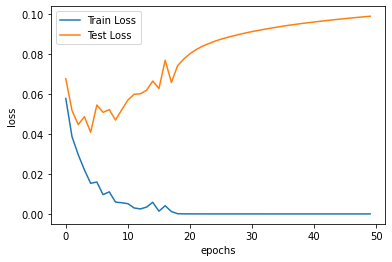

In [58]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(test_loss)), test_loss)
plt.legend(['Train Loss','Test Loss'])

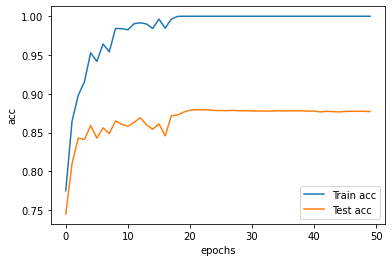

In [59]:
#准确率
plt.xlabel('epochs')
plt.ylabel('acc')
plt.plot(np.arange(len(train_acc)), train_acc)
plt.plot(np.arange(len(test_acc)), test_acc)
plt.legend(['Train acc','Test acc'])

In [60]:
print('测试集最高准确率: ', max(test_acc), '\t索引:',test_acc.index(max(test_acc)))

测试集最高准确率:  0.8794 	索引: 21
